# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
참조 : https://wikidocs.net/44249

루브릭
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.  
==> 3가지 이상의 모델이 성공적으로 시도됨  
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.  
==> gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함  
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.  
==> 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 1. 데이터 준비와 확인

### 1-1 필요한 모듈 import하기

In [39]:
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

### 1-2 데이터 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()  # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 훈련 및 테스트 데이터의 리뷰 개수 확인
print('훈련 데이터 형태 :', train_data.shape)
print('테스트 데이터 형태 :', test_data.shape)

훈련 데이터 형태 : (150000, 3)
테스트 데이터 형태 : (50000, 3)


In [4]:
# 훈련 데이터의 컬럼 이름 확인
print(train_data.columns)

Index(['id', 'document', 'label'], dtype='object')


## 2. 데이터로더 구성
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

### 2-1. 데이터 전처리

In [5]:
# 중복하지 않은 데이터의 개수
train_data[['document', 'label']].nunique()

document    146182
label            2
dtype: int64

학습용 데이터는 (150,000 - 146,182) = 3,818 개의 리뷰가 중복되고, 레이블은 0과 1만 있으므로 중복하지 않는 개수는 2개 뿐이다. 

<AxesSubplot:>

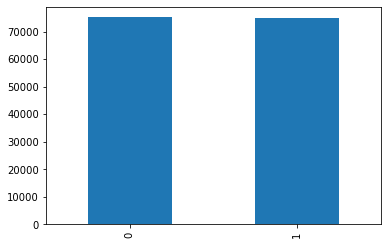

In [6]:
# 긍정, 부정 분포 그리기
train_data['label'].value_counts().plot(kind = 'bar')

In [7]:
# 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")

train_data[:5]

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [8]:
# train_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)
# 다시 한 번 Null 값이 존재하는지 확인
train_data.isnull().sum()

id            0
document    694
label         0
dtype: int64

* 한글과 숫자로 이루어 지지않은 행의 개수가 694개 이다.

In [9]:
# Null 값이 있는 행 5개만 출력
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1
2648,423224,NaN,1


In [10]:
# NaN은 아무런 의미가 없는 데이터 이므로 제거
train_data = train_data.dropna(how = 'any')

print('전처리 후 학습용 데이터 개수 :', len(train_data))

전처리 후 학습용 데이터 개수 : 149306


In [11]:
# 테스트 데이터도 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")
# test_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)
# NaN은 아무런 의미가 없는 데이터 이므로 제거
test_data = test_data.dropna(how = 'any')

print('전처리 후 테스트용 데이터 개수 :', len(test_data))

전처리 후 테스트용 데이터 개수 : 49773


/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


### 2-2. 토큰화, 불용어 제거, workd_to_index
* 한국어를 토큰화할 때는 형태소 분석기를 사용한다.
* 자연어 처리를 하기 위해서 긴 텍스트를 단어별로 쪼개는 작업이다.
* 토큰화 과정에서 불용어를 제거한다.
* 토큰화된 단어들을 인덱스로 변환한다.

In [12]:
# Mecab 설치 참고 : https://somjang.tistory.com/entry/PythonUbuntu에-mecab-ko-dic-라이브러리-설치하기
from konlpy.tag import Mecab        # Mecab : 일본어 형태소 분석기

# 형태소 분석기 객체 생성
tokenizer = Mecab()

# 불용어 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 학습용 데이터에서 document 열에서 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 학습용 데이터에서 Null 값이 존재하는 행 제거
    train_data = train_data.dropna(how = 'any') 
    # 테스트용 데이터에서 document 열에서 중복 데이터 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 테스트용 데이터에서 Null 값이 존재하는 행 제거
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 형태소 단위로 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 형태소 단위로 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()   # .tolist() : array를 list로 변경
    counter = Counter(words)                   # collection 모듈의 Counter 클래스로 데이터의 개수 확인
    counter = counter.most_common(10000-4)     # most_common() : 데이터의 개수가 많은 순으로 정렬된 배열 리턴
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        # wordlist에 있는 word에 대해서 만약에 word가 word_to_index에 존재하면 인덱스 값을, 존재하지 않으면 <UNK>를 인덱스로 반환함

    x_train = list(map(wordlist_to_indexlist, x_train))   # x_train 대상으로 wordlist_to_indexlist 함수를 수행하여 리스트로 반환
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [13]:
print("훈련 데이터 개수: {},  테스트 데이터 개수: {}".format(len(x_train), len(x_test)))

훈련 데이터 개수: 143856,  테스트 데이터 개수: 48498


In [14]:
# key= index, value= word로 변경
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '안',
 22: '적',
 23: '로',
 24: '정말',
 25: '것',
 26: '음',
 27: '네요',
 28: '아',
 29: '어',
 30: '점',
 31: '지만',
 32: '같',
 33: '재밌',
 34: '진짜',
 35: '했',
 36: '에서',
 37: '기',
 38: '않',
 39: '네',
 40: '거',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: '인',
 46: '말',
 47: '연기',
 48: '주',
 49: '평점',
 50: '내',
 51: '최고',
 52: '이런',
 53: '던',
 54: '생각',
 55: 'ㅎ',
 56: '할',
 57: '왜',
 58: '어요',
 59: '겠',
 60: '스토리',
 61: '습니다',
 62: '해',
 63: '듯',
 64: '아니',
 65: '드라마',
 66: '1',
 67: '그',
 68: '사람',
 69: '싶',
 70: '더',
 71: '함',
 72: '때',
 73: '감동',
 74: '배우',
 75: '본',
 76: '까지',
 77: '알',
 78: '만들',
 79: '내용',
 80: '뭐',
 81: '볼',
 82: '감독',
 83: '보다',
 84: '라',
 85: '지루',
 86: '재미',
 87: 'ㅋㅋ',
 88: '그냥',
 89: '시간',
 90: '중',
 91: '재미있',
 92: '년',
 93: '였',
 94: '10',
 95

In [15]:
# 활용할 딕셔너리와 함께 문장 1개를 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 3-1. 데이터셋 내 문장 길이 분포

In [16]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.073962589808374
문장길이 최대 :  84
문장길이 표준편차 :  11.57762930071467


### 3-2. 적절한 최대 문장 길이 지정

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

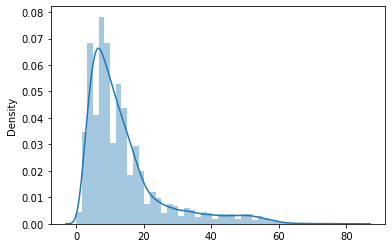

In [17]:
# 문장 길이 분포 시각화
sns.distplot(num_tokens)

In [18]:
# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

pad_sequences maxlen :  48
전체 문장의 97.07986316894892%가 maxlen 설정값 이내에 포함됩니다. 


### 3-3. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [19]:
# 문장의 길이가 maxlen 보다 짧은 문장에는 <PAD>를 추가
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print('shape of x_train : ', x_train.shape)
print('shape of x_test : ', x_test.shape)

shape of x_train :  (143856, 48)
shape of x_test :  (48498, 48)


## 4. 모델구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 4-1. train set, validation set 구성

In [20]:
print(int(x_train.shape[0]*0.8))

115084


In [21]:
# train data set에서 8:2의 비율로 train과 validation으로 분리, RNN에서는 순서가 중요하므로 shuffle은 진행하지 않도록 한다.
# train set
partial_x_train = x_train[:int(x_train.shape[0]*0.8)]
partial_y_train = y_train[:int(y_train.shape[0]*0.8)]

# validation set
x_valid = x_train[int(x_train.shape[0]*0.8):]
y_valid = y_train[int(x_train.shape[0]*0.8):]

print(partial_x_train.shape, partial_y_train.shape)
print(x_valid.shape, y_valid.shape)

(115084, 48) (115084,)
(28772, 48) (28772,)


### 4-2-1. RNN 모델

In [80]:
vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원 

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model1.add(keras.layers.LSTM(128))                        #  RNN에서 가장 널리 사용하는 LSTM 레이어 사용
model1.add(keras.layers.GRU(128))                            # LSTM 모델을 발전 시킨 모델
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim 

model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               126720    
_________________________________________________________________
dense_18 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 2,128,801
Trainable params: 2,128,801
Non-trainable params: 0
_________________________________________________________________


### 4-2-2. RNN 모델 훈련

In [81]:
# 학습 환경 설정
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/20
225/225 [==============================] - 8s 35ms/step - loss: 0.4139 - accuracy: 0.8097 - val_loss: 0.3571 - val_accuracy: 0.8434
Epoch 2/20
225/225 [==============================] - 8s 34ms/step - loss: 0.3211 - accuracy: 0.8620 - val_loss: 0.3379 - val_accuracy: 0.8524
Epoch 3/20
225/225 [==============================] - 8s 34ms/step - loss: 0.2839 - accuracy: 0.8792 - val_loss: 0.3345 - val_accuracy: 0.8553
Epoch 4/20
225/225 [==============================] - 8s 34ms/step - loss: 0.2540 - accuracy: 0.8924 - val_loss: 0.3555 - val_accuracy: 0.8544
Epoch 5/20
225/225 [==============================] - 8s 35ms/step - loss: 0.2284 - accuracy: 0.9041 - val_loss: 0.3793 - val_accuracy: 0.8478
Epoch 6/20
225/225 [==============================] - 8s 34ms/step - loss: 0.2058 - accuracy: 0.9146 - val_loss: 0.3914 - val_accuracy: 0.8482
Epoch 7/20
225/225 [==============================] - 8s 34ms/step - loss: 0.1846 - accuracy: 0.9234 - val_loss: 0.4395 - val_accuracy: 0.8461

### 4-2-3. Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


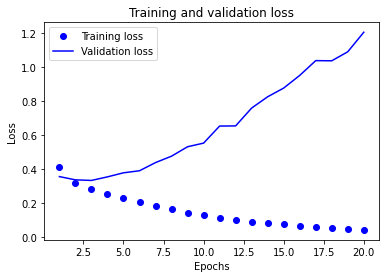

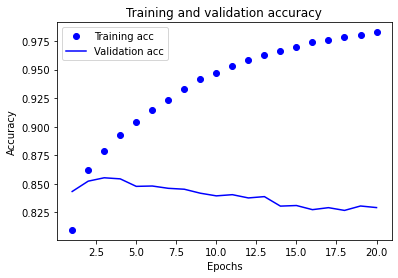

In [82]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

loss(손실) 와 acc(정확도) 결과를 보면은 epoch가 2 이상부터 오버피팅이 발생하기 시작하므로 더이상 학습하는 것은 의미가 없다.

### 4-2-4. 테스트 평가

In [83]:
# test 결과
results = model1.evaluate(x_test, y_test, verbose=2)

print(results)

1516/1516 - 4s - loss: 1.1726 - accuracy: 0.8313
[1.1726402044296265, 0.8313126564025879]


* word_vector_dim = 100, LSTM(128), Dens(16) : loss: 1.0632 - accuracy: 0.8322
* word_vector_dim = 100, GRU(128) , Dens(16) : loss: 0.9622 - accuracy: 0.8297
* word_vector_dim = 200, GRU(128) , Dens(16) : loss: 1.1726 - accuracy: 0.8313
* word_vector_dim = 300, GRU(128) , Dens(16) : loss: 1.2849 - accuracy: 0.8349

### 4-3-1. 1-D Convolution Neural Network(1-D CNN) 모델

In [84]:
vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

### 4-3-2. 1-D CNN 모델 훈련

In [85]:
# 학습 환경 설정
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/20
225/225 [==============================] - 8s 34ms/step - loss: 0.5238 - accuracy: 0.7206 - val_loss: 0.4222 - val_accuracy: 0.8005
Epoch 2/20
225/225 [==============================] - 4s 16ms/step - loss: 0.3869 - accuracy: 0.8200 - val_loss: 0.4082 - val_accuracy: 0.8093
Epoch 3/20
225/225 [==============================] - 3s 15ms/step - loss: 0.3376 - accuracy: 0.8474 - val_loss: 0.4190 - val_accuracy: 0.8087
Epoch 4/20
225/225 [==============================] - 3s 15ms/step - loss: 0.2839 - accuracy: 0.8759 - val_loss: 0.4440 - val_accuracy: 0.8045
Epoch 5/20
225/225 [==============================] - 3s 15ms/step - loss: 0.2273 - accuracy: 0.9032 - val_loss: 0.4991 - val_accuracy: 0.7977
Epoch 6/20
225/225 [==============================] - 3s 15ms/step - loss: 0.1790 - accuracy: 0.9236 - val_loss: 0.5783 - val_accuracy: 0.7967
Epoch 7/20
225/225 [==============================] - 3s 15ms/step - loss: 0.1451 - accuracy: 0.9380 - val_loss: 0.6636 - val_accuracy: 0.7904

### 4-3-3. Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


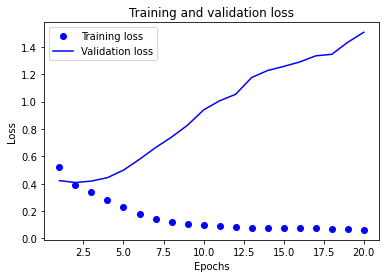

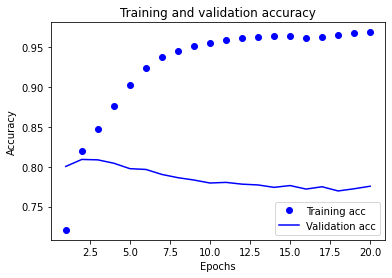

In [87]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

LSTM과 GRU 모델에서와 같이 epoch 2번부터 오버피팅이 발생하고 있음

### 4-3-4. 테스트 평가

In [88]:
# test 결과
results = model2.evaluate(x_test, y_test, verbose=2)

print(results)

1516/1516 - 4s - loss: 1.4916 - accuracy: 0.7722
[1.4916458129882812, 0.7722173929214478]


* word_vector_dim = 100, Conv1D(16, 7), Dense(8) : loss: 1.4916 - accuracy: 0.7722
* word_vector_dim = 200, Conv1D(16, 7), Dense(8) : loss: 1.5501 - accuracy: 0.7721
* word_vector_dim = 300, Conv1D(16, 7), Dense(8) : loss: 1.5164 - accuracy: 0.7737

### 4-4-1. 학습된 Embedding 레이어 모델

In [70]:
# 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [71]:
import os
from gensim import models     # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.09812401,  0.07963714,  0.00582482,  0.06545677,  0.00481287,
        0.02649019,  0.01814787,  0.08244572,  0.01096472, -0.00303867,
        0.0367174 , -0.06245502, -0.00223387,  0.10249247, -0.05462897,
        0.02814103, -0.02771148,  0.02228487,  0.00781817,  0.00868889,
       -0.00978768,  0.05880191,  0.02953784, -0.08400371,  0.03104752,
        0.01676674, -0.06293654, -0.00278644, -0.00274821,  0.05343545,
        0.04808955,  0.03045266, -0.02847589, -0.00809071, -0.01802203,
       -0.00316189, -0.02982008, -0.0038577 ,  0.01644477,  0.00211412,
        0.03666341,  0.00808282, -0.02521199,  0.00798019, -0.02608682,
        0.03985018, -0.03940862,  0.03093593,  0.03029227, -0.05979111,
        0.0617682 , -0.04527944, -0.05232496, -0.07321536, -0.0601343 ,
       -0.00522263, -0.03441272, -0.04295403,  0.00903911,  0.01802345,
        0.00677624,  0.00052975, -0.0603122 , -0.03215264,  0.06117329,
        0.02147835,  0.05640343, -0.00949121, -0.00382649,  0.02

In [49]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("할인")

[('꺼져라', 0.6274117827415466),
 ('부대', 0.6039007902145386),
 ('맞짱', 0.6008872985839844),
 ('쳐라', 0.6008428931236267),
 ('최시원', 0.5950552225112915),
 ('함량', 0.5923036932945251),
 ('장르노', 0.574643611907959),
 ('큐브', 0.5687328577041626),
 ('구사', 0.5611624121665955),
 ('퍽', 0.5515892505645752)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
https://github.com/Kyubyong/wordvectors

* **Work Flow**
 - STEP 1. Download the wikipedia database backup dumps of the language you want.
 - STEP 2. Extract running texts to data/ folder.
 - STEP 3. Run build_corpus.py.
 - STEP 4-1. Run make_wordvector.sh to get Word2Vec word vectors.
 - STEP 4-2. Run fasttext.sh to get fastText word vectors.
  
  
* **Pre-trained models**
 - Two types of pre-trained models are provided. w and f represent word2vec and fastText respectively.   
 


### 사전에 학습된 Word2Vec 등의 임베딩 모델(ko.bin)을 활용하는 전이학습(Transfer Learning)

In [72]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

vector = word2vec['거북선']
vector     

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-2.12308183e-01, -5.68490446e-01, -2.60044247e-01, -1.32914290e-01,
        2.06298992e-01,  2.06169486e-01,  1.04142666e-01, -5.03747344e-01,
       -2.59315282e-01, -5.63449204e-01, -5.42806268e-01,  1.23673573e-01,
       -5.65214813e-01,  1.44688830e-01,  2.58647621e-01,  7.76652873e-01,
       -2.37872958e-01,  2.15301275e-01, -2.38817304e-01,  1.12165764e-01,
       -2.87356853e-01,  2.23779500e-01,  3.66175063e-02,  6.32265270e-01,
       -1.67528600e-01,  2.57706523e-01,  5.33879660e-02, -1.01358622e-01,
        3.90055090e-01,  7.96726346e-01, -2.04774648e-01, -4.91633713e-01,
       -6.18211031e-01, -1.05088092e-02,  2.78530002e-01,  3.82351995e-01,
        4.73394603e-01,  5.93742847e-01, -4.52139080e-01,  9.34170410e-02,
        3.21552128e-01, -3.13829601e-01,  8.27486515e-01,  6.75750291e-03,
        7.44879320e-02,  1.70621559e-01, -1.32197693e-01,  2.68836450e-02,
        1.11467347e-01,  2.15042189e-01,  8.54768902e-02,  3.64891469e-01,
        1.83106631e-01,  

In [54]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("전략")

[('도저', 0.8324468731880188),
 ('어이', 0.8277930617332458),
 ('헛웃음', 0.8228403925895691),
 ('역행', 0.8157042264938354),
 ('서세원', 0.8118122816085815),
 ('먹칠', 0.8024115562438965),
 ('엉망진창', 0.8019837737083435),
 ('으려다', 0.7995085716247559),
 ('지저분', 0.7988393306732178),
 ('아포칼립토', 0.7978097796440125)]

In [73]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


ValueError: could not broadcast input array from shape (200) into shape (300)

In [74]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.MaxPooling1D(5))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.GlobalMaxPooling1D())
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 48, 300)           3000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 42, 16)            33616     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [75]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/20
225/225 [==============================] - 9s 38ms/step - loss: 0.6933 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 2/20
225/225 [==============================] - 8s 37ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 3/20
225/225 [==============================] - 9s 38ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 4/20
225/225 [==============================] - 8s 37ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 5/20
225/225 [==============================] - 8s 36ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 6/20
225/225 [==============================] - 8s 36ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 7/20
225/225 [==============================] - 8s 36ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5051

### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


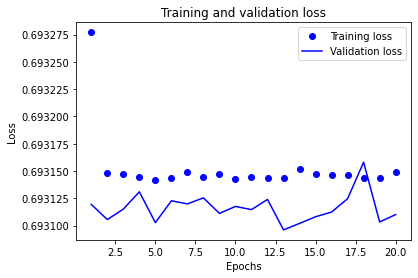

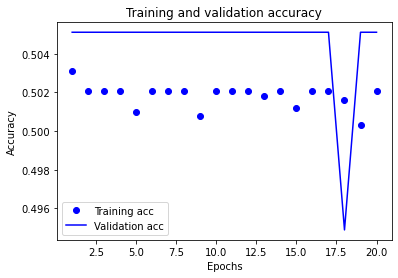

In [76]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [77]:
# 테스트셋을 통한 모델 평가
results = model4.evaluate(x_test,  y_test, verbose=2)

print(results)

1516/1516 - 3s - loss: 0.6932 - accuracy: 0.4985
[0.693173885345459, 0.4984947741031647]


* word_vector_dim = 100 : loss: 1.0018 - accuracy: 0.7719
* word_vector_dim = 200 : loss: 1.0018 - accuracy: 0.7719
* word_vector_dim = 300 : loss: 0.6932 - accuracy: 0.4985

## 회고